## BEFORE THE START, QUICK CHECK on Stokes parameters of binned & convolved data!
## Binning and convolution were applied to entire original file (via superast)!

In [75]:
# Import necessary packages

import MilneEddington as ME
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import utils as ut

In [76]:
superast_bc_data = fits.open('binned_convolved_stokes.fits')[0].data[:85, :85, :, :] # og shape is (512, 512, 4, 201)
stokes = fits.open('qs_ph_disk_center_synth.fits')[0].data[:256, :256, :, :]
print(superast_bc_data.shape)

(85, 85, 4, 201)


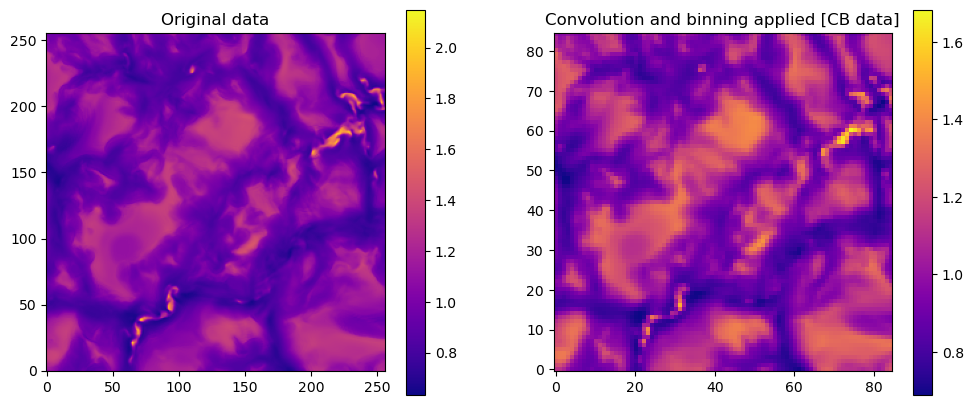

In [65]:
# Comparison for the starters
plt.figure(figsize=[12, 5])

plt.subplot(1, 2, 1)
plt.imshow(stokes[:, :, 0, 0], origin='lower', cmap='plasma')
plt.title(r'Original data')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(superast_bc_data[:, :, 0, 0], origin='lower', cmap='plasma')
plt.title(r'Convolution and binning applied [CB data]')
plt.colorbar()
plt.show()

In [66]:
# Printing mean values

print(np.mean(stokes[:,:,0,0]))
print(np.mean(superast_bc_data[:,:,0,0]))

1.0157715116074542
1.0158706152847514


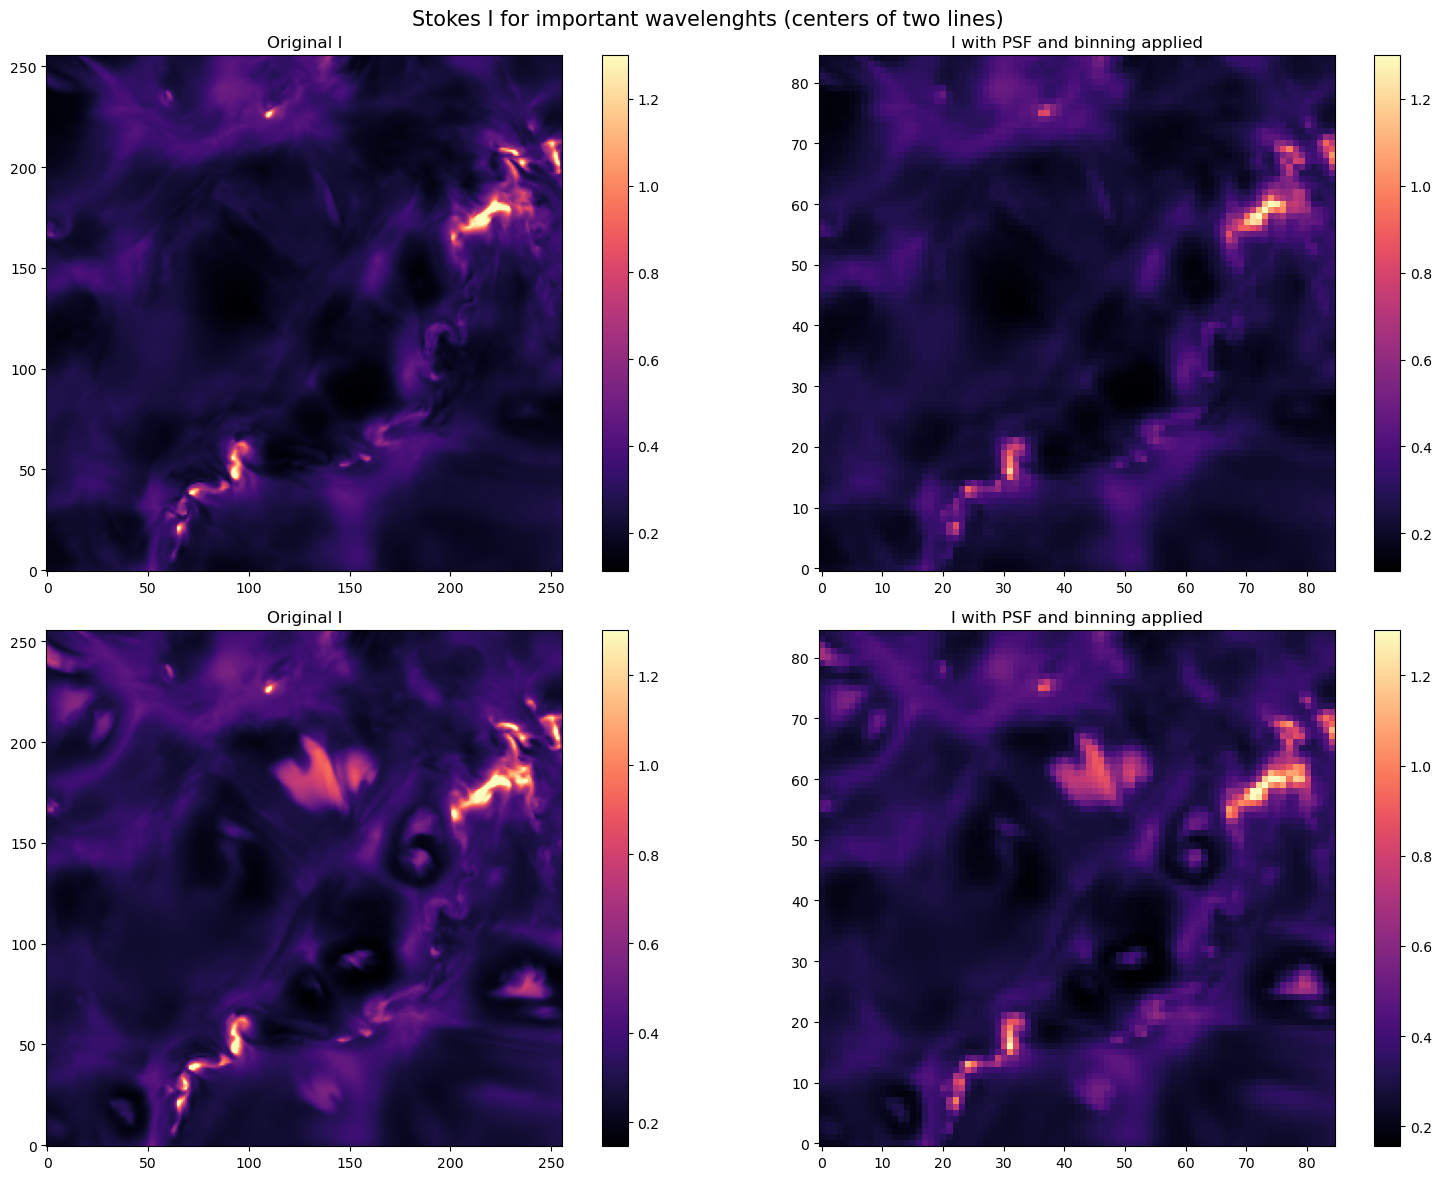

In [14]:
# Stokes I

plt.figure(figsize=(16, 12))
plt.suptitle('Stokes I for important wavelenghts (centers of two lines)', fontsize=15)

plt.subplot(2, 2, 1)
plt.imshow(stokes[:,:,0, 50], origin='lower', cmap='magma', vmax=1.3)
plt.colorbar()
plt.title('Original I')

plt.subplot(2, 2, 2)
plt.imshow(superast_bc_data[:,:,0, 50], origin='lower', cmap='magma', vmax=1.3)
plt.colorbar()
plt.title('I with PSF and binning applied')

plt.subplot(2, 2, 3)
plt.imshow(stokes[:,:,0, 150], origin='lower', cmap='magma', vmax=1.3)
plt.colorbar()
plt.title('Original I')

plt.subplot(2, 2, 4)
plt.imshow(superast_bc_data[:,:,0, 150], origin='lower', cmap='magma', vmax=1.3)
plt.colorbar()
plt.title('I with PSF and binning applied')

plt.tight_layout()
plt.show()

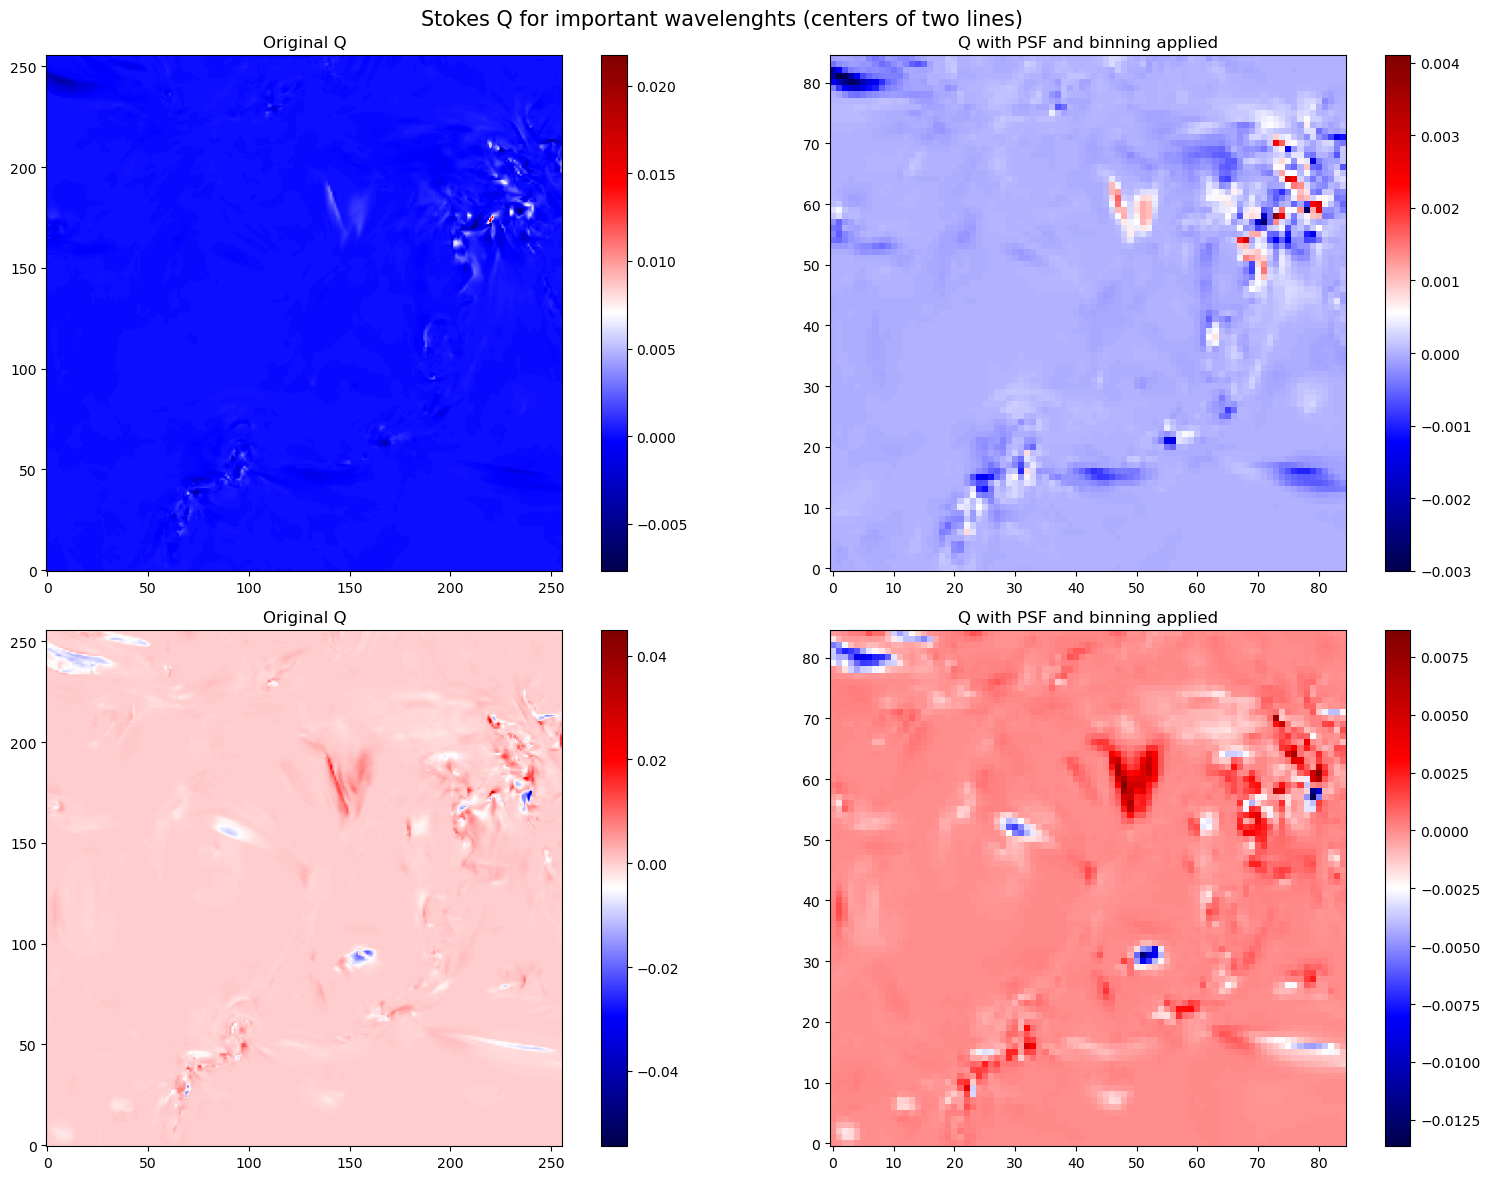

In [16]:
# Stokes Q

plt.figure(figsize=(16, 12))
plt.suptitle('Stokes Q for important wavelenghts (centers of two lines)', fontsize=15)

plt.subplot(2, 2, 1)
plt.imshow(stokes[:,:,1, 50], origin='lower', cmap='seismic')
plt.colorbar()
plt.title('Original Q')

plt.subplot(2, 2, 2)
plt.imshow(superast_bc_data[:,:,1, 50], origin='lower', cmap='seismic')
plt.colorbar()
plt.title('Q with PSF and binning applied')

plt.subplot(2, 2, 3)
plt.imshow(stokes[:,:,1, 150], origin='lower', cmap='seismic')
plt.colorbar()
plt.title('Original Q')

plt.subplot(2, 2, 4)
plt.imshow(superast_bc_data[:,:,1, 150], origin='lower', cmap='seismic')
plt.colorbar()
plt.title('Q with PSF and binning applied')

plt.tight_layout()
plt.show()

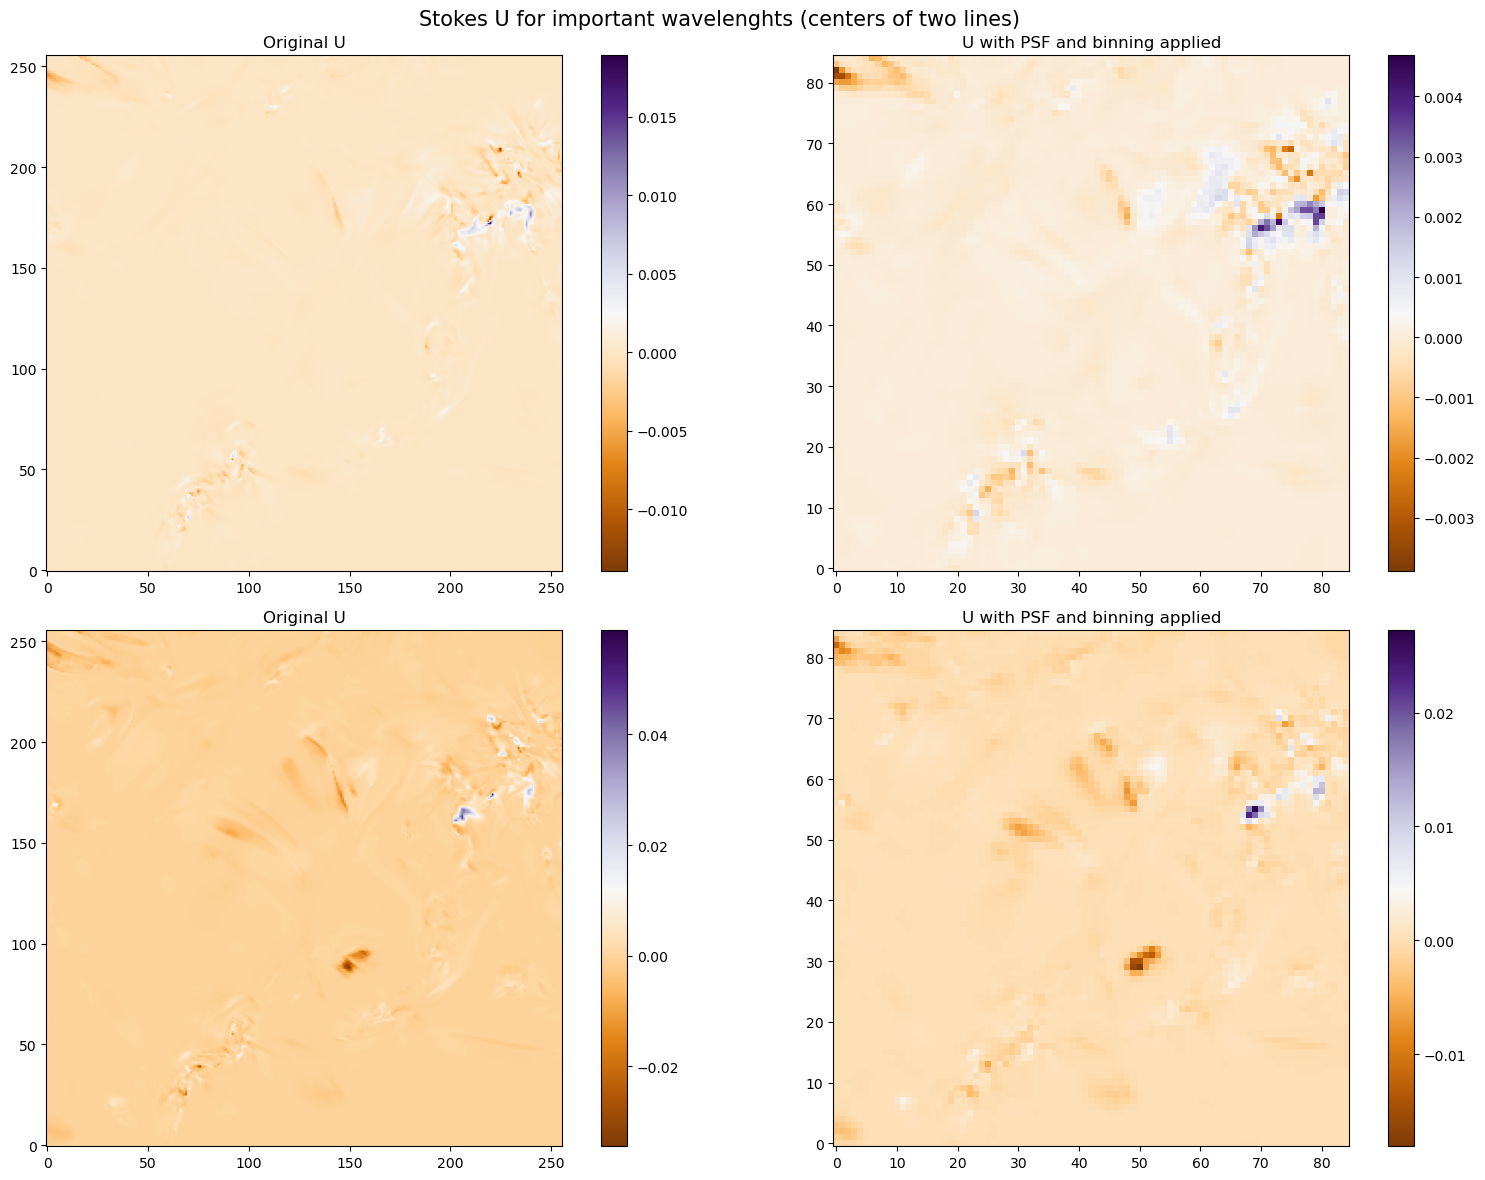

In [17]:
# Stokes U

plt.figure(figsize=(16, 12))
plt.suptitle('Stokes U for important wavelenghts (centers of two lines)', fontsize=15)

plt.subplot(2, 2, 1)
plt.imshow(stokes[:,:,2, 50], origin='lower', cmap='PuOr')
plt.colorbar()
plt.title('Original U')

plt.subplot(2, 2, 2)
plt.imshow(superast_bc_data[:,:,2, 50], origin='lower', cmap='PuOr')
plt.colorbar()
plt.title('U with PSF and binning applied')

plt.subplot(2, 2, 3)
plt.imshow(stokes[:,:,2, 150], origin='lower', cmap='PuOr')
plt.colorbar()
plt.title('Original U')

plt.subplot(2, 2, 4)
plt.imshow(superast_bc_data[:,:,2, 150], origin='lower', cmap='PuOr')
plt.colorbar()
plt.title('U with PSF and binning applied')

plt.tight_layout()
plt.show()

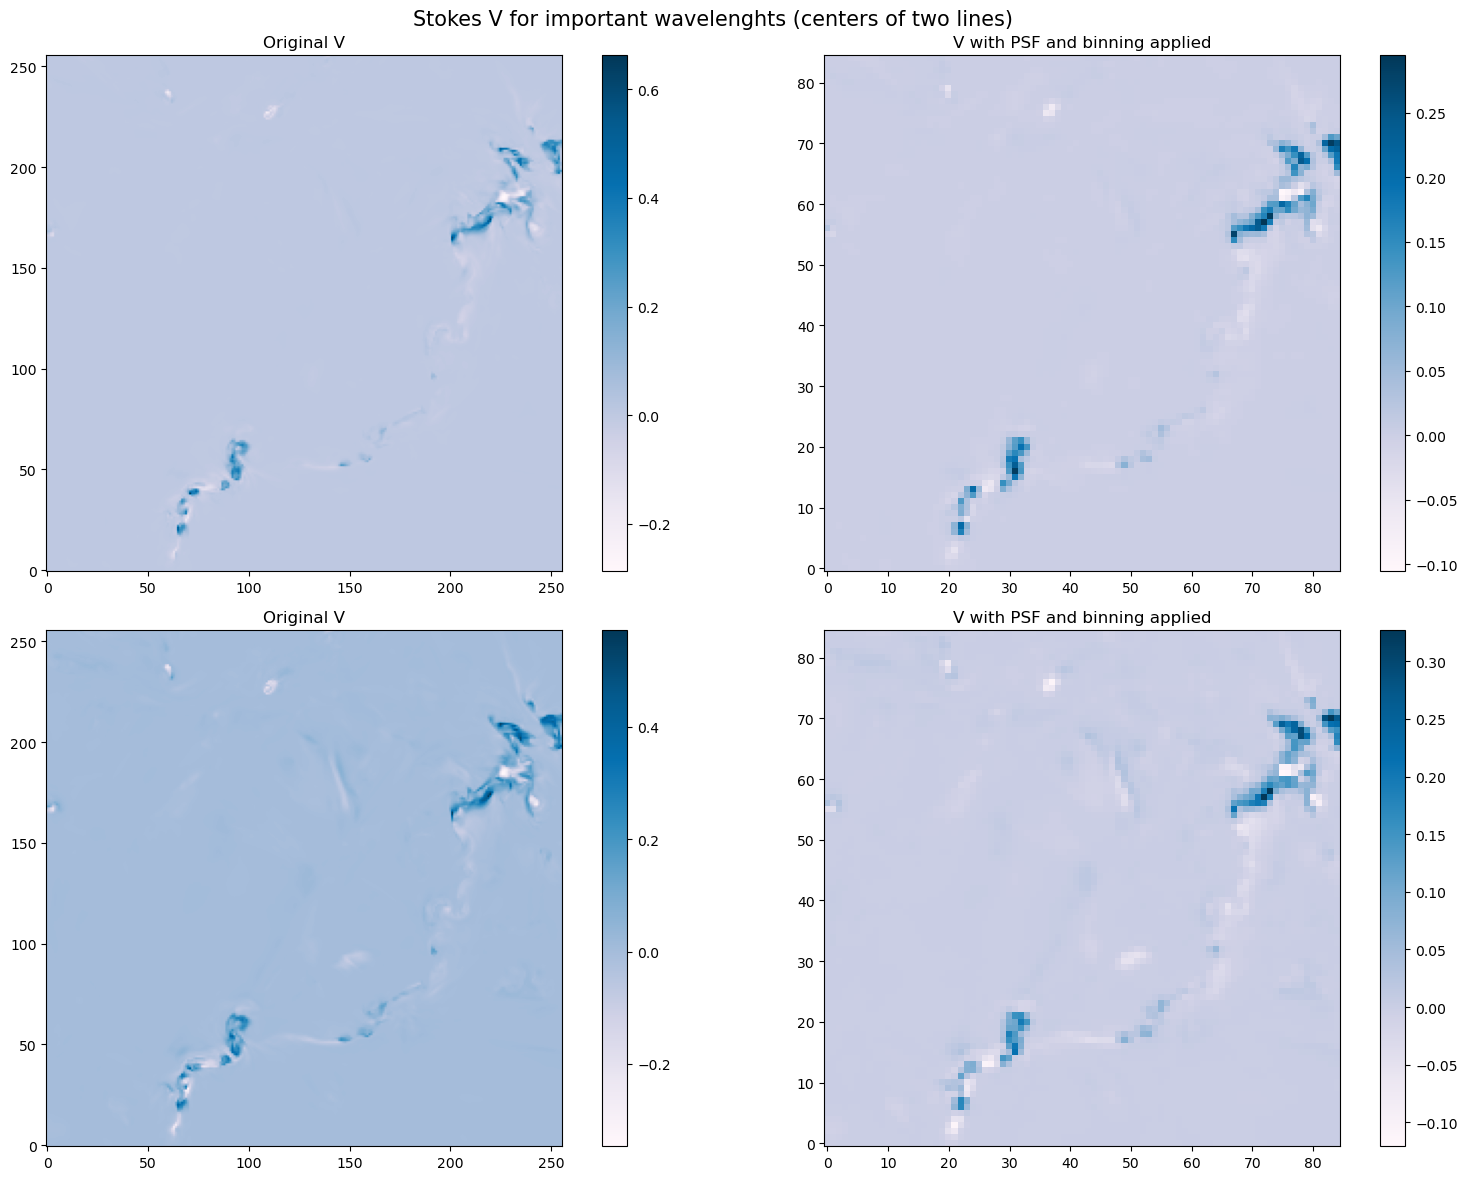

In [18]:
# Stokes V

plt.figure(figsize=(16, 12))
plt.suptitle('Stokes V for important wavelenghts (centers of two lines)', fontsize=15)

plt.subplot(2, 2, 1)
plt.imshow(stokes[:,:,3, 50], origin='lower', cmap='PuBu')
plt.colorbar()
plt.title('Original V')

plt.subplot(2, 2, 2)
plt.imshow(superast_bc_data[:,:,3, 50], origin='lower', cmap='PuBu')
plt.colorbar()
plt.title('V with PSF and binning applied')

plt.subplot(2, 2, 3)
plt.imshow(stokes[:,:,3, 150], origin='lower', cmap='PuBu')
plt.colorbar()
plt.title('Original V')

plt.subplot(2, 2, 4)
plt.imshow(superast_bc_data[:,:,3, 150], origin='lower', cmap='PuBu')
plt.colorbar()
plt.title('V with PSF and binning applied')

plt.tight_layout()
plt.show()

# NOW, INVERSION IS BEING DONE!

In [77]:
# Importing data AGAIN (smaller portions)
# data doesn't need to be normalized

binned_convolved_stokes = fits.open('binned_convolved_stokes.fits')[0].data[:85,:85,:,:]
psf = fits.open('psf_1m_binned.fits')[0].data 

print(binned_convolved_stokes.shape, psf.shape) # binned psf of course

(85, 85, 4, 201) (19, 19)


In [78]:
# INVERSION

def waveGrid(nw):
    
    wav = np.arange(nw) * 0.01 + 6301.0
    return wav
    
def loadData(clip_threshold = 0.99):

    obs = binned_convolved_stokes
    wav = waveGrid(obs.shape[-1])
 
    sig = np.zeros([4,len(wav)])
    sig[:,:] = 1e-3
    sig[1:4,:] /= 2.0
    
    return [[wav, None]], [[obs, sig, psf, clip_threshold]]


if __name__ == "__main__":

    nthreads = 2 # adapt this number to the number of cores that are available in your machine
    
    # Load data
    region, sregion = loadData()

    # Init ME inverter
    me = ME.MilneEddington(region, [6301, 6302], nthreads=nthreads)
    
    # generate initial model
    ny, nx = sregion[0][0].shape[0:2]
    Ipar = np.float64([500., 0.1, 0.1, 0.0, 0.04, 100, 0.5, 0.1, 1.0]) # pay attention to the B value
    m = me.repeat_model(Ipar, ny, nx)
    

    # Invert pixel by pixel
    mpix, syn, chi2 = me.invert(m, sregion[0][0], nRandom=8, nIter=10, chi2_thres=1.0, mu=0.96)

pyMilne::dealloc: cleaning-up...


line::line: Initialized [6301.499500] ->  12 Zeeman components
line::line: Initialized [6302.493100] ->   3 Zeeman components
InvertMany: Processed -> 100%


pyMilne::dealloc: cleaning-up...


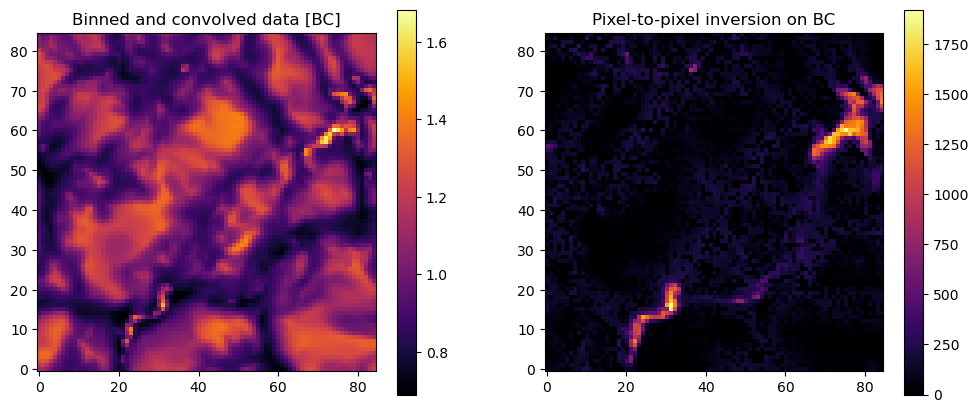

In [73]:
plt.figure(figsize=[12, 5])
!
plt.subplot(1, 2, 1)
plt.imshow(binned_convolved_stokes[:85, :85, 0, 0], origin='lower', cmap='inferno')
plt.title(r'Binned and convolved data [BC]')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(mpix[:, :, 0], origin='lower', cmap='inferno')
plt.title(r'Pixel-to-pixel inversion on BC')
plt.colorbar()
plt.show()